In [1]:
import gymnasium as gym
import numpy as np
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [2]:
import gc
gc.collect()

7

In [3]:
!nvidia-smi

# clean up memory forcefully
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device





Sat Apr 13 22:54:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   40C    P8              16W / 250W |    796MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.norm1 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 32)
        self.norm2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x)))
        x = F.relu(self.norm2(self.fc2(x)))
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    

Using device: cuda


In [5]:
env_id = "CartPole-v1"
# env = make_vec_env(env_id, n_envs=1)
observations= np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_obs.npy", allow_pickle=True)
actions = np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_actions.npy", allow_pickle=True)
rewards = np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_rewards.npy", allow_pickle=True)
dones = np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_dones.npy", allow_pickle=True)
info = np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_info.npy", allow_pickle=True)
next_obs = np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()

# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])

# print(actions)

(28000, 4) (28000,) (28000,) (28000,) (28000,) (28000, 4)
[-0.0455423  -0.00493775  0.01715994  0.02859923] 0 1.0 False {'TimeLimit.truncated': False} [-0.04564106 -0.20030153  0.01773192  0.32664654]


In [6]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [7]:
import numpy as np
import gymnasium as gym
from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env
from imitation.data.wrappers import RolloutInfoWrapper

env = make_vec_env(
    "seals:seals/CartPole-v0",
    rng=np.random.default_rng(),
    post_wrappers=[
        lambda env, _: RolloutInfoWrapper(env)
    ],  # needed for computing rollouts later
)
expert = load_policy(
    "ppo-huggingface",
    organization="HumanCompatibleAI",
    env_name="seals/CartPole-v0",
    venv=env,
)

/mnt/nfs/work/c98181/miniconda3/envs/atari/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from stable_baselines3.common.evaluation import evaluate_policy

reward, _ = evaluate_policy(expert, env, 10)
print(reward)

500.0


In [9]:
from imitation.data import rollout, types as rtypes

In [10]:

rng = np.random.default_rng()
rollouts = rollout.rollout(
    expert,
    env,
    rollout.make_sample_until(min_timesteps=None, min_episodes=50),
    rng=rng,
)
transitions = rollout.flatten_trajectories(rollouts)

In [11]:
print(transitions.obs.shape, transitions.acts.shape)
my=rtypes.Transitions(obs=observations, acts=actions, dones=dones, infos=info, next_obs=next_obs)


(28000, 4) (28000,)


In [12]:
print(
    f"""The `rollout` function generated a list of {len(rollouts)} {type(rollouts[0])}.
After flattening, this list is turned into a {type(transitions)} object containing {len(transitions)} transitions.
The transitions object contains arrays for: {', '.join(transitions.__dict__.keys())}."
"""
)


The `rollout` function generated a list of 56 <class 'imitation.data.types.TrajectoryWithRew'>.
After flattening, this list is turned into a <class 'imitation.data.types.Transitions'> object containing 28000 transitions.
The transitions object contains arrays for: obs, acts, infos, next_obs, dones."



In [13]:
from imitation.algorithms import bc
bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=my,
    rng=rng,
    device="cpu"
)
print(bc_trainer.policy)

FeedForward32Policy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=32, out_features=2, bias=True)
  (value_net): Linear(in_features=32, out_features=1, bias=True)
)


In [14]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, env, 10)
print(f"Reward before training: {reward_before_training}")

Reward before training: 89.7


In [15]:
bc_trainer.train(n_epochs=1)
reward_after_training, _ = evaluate_policy(bc_trainer.policy, env, 10)
print(f"Reward after training: {reward_after_training}")

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.692     |
|    neglogp        | 0.692     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
---------------------------------


472batch [00:01, 439.31batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000238 |
|    entropy        | 0.238     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 94.1      |
|    loss           | 0.164     |
|    neglogp        | 0.164     |
|    prob_true_act  | 0.878     |
|    samples_so_far | 16032     |
---------------------------------


875batch [00:02, 432.58batch/s]


Reward after training: 500.0


In [16]:
# show line number below
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3

policy_network = PolicyNetwork(
    4, 2).to(device)
# nn init kaiming
torch.nn.init.kaiming_normal_(policy_network.fc1.weight)
torch.nn.init.kaiming_normal_(policy_network.fc2.weight)
torch.nn.init.kaiming_normal_(policy_network.fc3.weight)

# build training set and validation set
train_size = int(1* len(observations))
train_observations = observations[:train_size]
train_actions = actions[:train_size]
# val_observations = observations[train_size:]
# val_actions = actions[train_size:]

# build dataset
train_dataset = CustomDataset(observations, actions)
# val_dataset = CustomDataset(val_observations, val_actions)
env = make_vec_env_sb3(env_id, n_envs=1)

optimizer = torch.optim.Adam(policy_network.parameters(), lr=0.0017601048183920826,weight_decay=2.350251568550711e-5,eps=1e-8)


# Training loop
num_epochs = 1
batch_size = 16

train_dataloader = DataLoader(train_dataset , batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset , batch_size=batch_size, shuffle=True)
loss_func = nn.CrossEntropyLoss()
log_interval = 500
num_test=10

now_log=0
now_pos=0
graph=[]
eval_rewards=[]
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(train_dataloader,position=0,leave=True)
    now_log=0
    
    for step, (obs_batch,act_batch) in enumerate(pbar):
        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        
        logits = policy_network(obs_batch)
        # cross entropy
        loss=loss_func(logits, act_batch.long())
        
        # Optimize the policy
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()




        #scheduler

        graph.append(loss.detach().item())
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            frames = []
            saved_frame = False
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()[0]
                        
                    state, reward, done, _ = env.step(action)  # 执行动作
                    total_reward += reward
                    if not saved_frame:
                        frame = env.render(mode="rgb_array")
                        frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
                if not saved_frame:
                    saved_frame = True
                    image_path = f"cartpole_iteration_{now_pos}.gif"
                    imageio.mimsave("/mnt/nfs/work/c98181/RL/CartPole-v1/BC/gif/"+image_path, frames)


            
            print(total_reward/num_test)
                
            eval_rewards.append(total_reward/num_test)

            policy_network.train()      
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        pbar.set_postfix({"loss":loss.detach().item()})
env.close()

    


Epoch [1/1]:   1%|          | 18/1750 [00:00<00:09, 178.29it/s, loss=0.223]/tmp/ipykernel_979611/552915670.py:82: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847094/work/torch/csrc/utils/tensor_new.cpp:275.)
  state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
Epoch [1/1]:   2%|▏         | 36/1750 [00:02<01:58, 14.53it/s, loss=0.376] 

[71.8]


Epoch [1/1]:   4%|▎         | 63/1750 [00:05<02:55,  9.60it/s, loss=0.301]

[91.7]


Epoch [1/1]:   5%|▌         | 94/1750 [00:10<03:33,  7.75it/s, loss=0.366]

[129.]


Epoch [1/1]:   7%|▋         | 125/1750 [00:14<03:29,  7.76it/s, loss=0.25] 

[172.4]


Epoch [1/1]:   9%|▉         | 157/1750 [00:17<02:53,  9.19it/s, loss=0.516]

[140.]


Epoch [1/1]:  11%|█         | 188/1750 [00:21<03:10,  8.19it/s, loss=0.447] 

[159.6]


Epoch [1/1]:  13%|█▎        | 219/1750 [00:25<03:13,  7.91it/s, loss=0.166]

[96.]


Epoch [1/1]:  14%|█▍        | 250/1750 [00:30<03:19,  7.51it/s, loss=0.42] 

[158.9]


Epoch [1/1]:  16%|█▌        | 282/1750 [00:32<02:49,  8.66it/s, loss=0.1]   

[154.1]


Epoch [1/1]:  18%|█▊        | 313/1750 [00:36<02:41,  8.92it/s, loss=0.433]

[140.7]


Epoch [1/1]:  20%|█▉        | 344/1750 [00:41<03:03,  7.66it/s, loss=0.102]

[218.2]


Epoch [1/1]:  21%|██▏       | 375/1750 [00:45<02:53,  7.95it/s, loss=0.637]

[125.5]


Epoch [1/1]:  23%|██▎       | 407/1750 [00:50<03:02,  7.36it/s, loss=0.348] 

[276.1]


Epoch [1/1]:  25%|██▌       | 438/1750 [01:02<04:38,  4.70it/s, loss=0.299]

[231.4]


Epoch [1/1]:  27%|██▋       | 469/1750 [01:07<04:20,  4.91it/s, loss=0.369]

[301.4]


Epoch [1/1]:  29%|██▊       | 500/1750 [01:17<04:55,  4.23it/s, loss=0.347]

[381.4]


Epoch [1/1]:  30%|███       | 532/1750 [01:24<04:44,  4.28it/s, loss=0.137]

[366.4]


Epoch [1/1]:  32%|███▏      | 563/1750 [01:38<05:52,  3.37it/s, loss=0.236]

[497.3]


Epoch [1/1]:  34%|███▍      | 594/1750 [01:49<05:59,  3.21it/s, loss=0.296]

[409.5]


Epoch [1/1]:  36%|███▌      | 625/1750 [02:02<06:24,  2.92it/s, loss=0.294] 

[398.9]


Epoch [1/1]:  38%|███▊      | 657/1750 [02:15<06:41,  2.73it/s, loss=0.346] 

[405.5]


Epoch [1/1]:  39%|███▉      | 688/1750 [02:28<06:40,  2.65it/s, loss=0.219]

[476.4]


Epoch [1/1]:  41%|████      | 719/1750 [02:41<06:40,  2.57it/s, loss=0.178]

[469.1]


Epoch [1/1]:  43%|████▎     | 750/1750 [02:53<06:33,  2.54it/s, loss=0.428]

[500.]


Epoch [1/1]:  45%|████▍     | 782/1750 [03:06<06:25,  2.51it/s, loss=0.333] 

[500.]


Epoch [1/1]:  46%|████▋     | 813/1750 [03:19<06:16,  2.49it/s, loss=0.23] 

[500.]


Epoch [1/1]:  48%|████▊     | 844/1750 [03:32<06:07,  2.47it/s, loss=0.264]

[500.]


Epoch [1/1]:  50%|█████     | 875/1750 [03:44<05:54,  2.47it/s, loss=0.312]

[500.]


Epoch [1/1]:  52%|█████▏    | 907/1750 [03:57<05:36,  2.50it/s, loss=0.235]

[500.]


Epoch [1/1]:  54%|█████▎    | 938/1750 [04:09<05:22,  2.52it/s, loss=0.138] 

[500.]


Epoch [1/1]:  55%|█████▌    | 969/1750 [04:21<05:07,  2.54it/s, loss=0.327] 

[500.]


Epoch [1/1]:  57%|█████▋    | 1000/1750 [04:33<04:52,  2.57it/s, loss=0.117] 

[500.]


Epoch [1/1]:  59%|█████▉    | 1032/1750 [04:45<04:38,  2.57it/s, loss=0.102] 

[500.]


Epoch [1/1]:  61%|██████    | 1063/1750 [04:57<04:24,  2.60it/s, loss=0.363] 

[500.]


Epoch [1/1]:  63%|██████▎   | 1094/1750 [05:08<04:11,  2.61it/s, loss=0.215] 

[500.]


Epoch [1/1]:  64%|██████▍   | 1125/1750 [05:20<03:59,  2.61it/s, loss=0.101] 

[500.]


Epoch [1/1]:  66%|██████▌   | 1157/1750 [05:32<03:43,  2.65it/s, loss=0.118]  

[500.]


Epoch [1/1]:  68%|██████▊   | 1188/1750 [05:44<03:32,  2.64it/s, loss=0.0794] 

[500.]


Epoch [1/1]:  70%|██████▉   | 1219/1750 [05:55<03:19,  2.66it/s, loss=0.156]  

[500.]


Epoch [1/1]:  71%|███████▏  | 1250/1750 [06:07<03:07,  2.67it/s, loss=0.0935]

[500.]


Epoch [1/1]:  73%|███████▎  | 1282/1750 [06:19<02:54,  2.68it/s, loss=0.141]  

[500.]


Epoch [1/1]:  75%|███████▌  | 1313/1750 [06:30<02:42,  2.68it/s, loss=0.157] 

[500.]


Epoch [1/1]:  77%|███████▋  | 1344/1750 [06:42<02:31,  2.69it/s, loss=0.0319] 

[500.]


Epoch [1/1]:  79%|███████▊  | 1375/1750 [06:53<02:19,  2.68it/s, loss=0.149]  

[500.]


Epoch [1/1]:  80%|████████  | 1407/1750 [07:05<02:07,  2.70it/s, loss=0.0376] 

[500.]


Epoch [1/1]:  82%|████████▏ | 1438/1750 [07:16<01:55,  2.69it/s, loss=0.151] 

[500.]


Epoch [1/1]:  84%|████████▍ | 1469/1750 [07:28<01:44,  2.68it/s, loss=0.0588] 

[500.]


Epoch [1/1]:  86%|████████▌ | 1500/1750 [07:40<01:32,  2.69it/s, loss=0.107]  

[500.]


Epoch [1/1]:  88%|████████▊ | 1532/1750 [07:51<01:20,  2.71it/s, loss=0.202] 

[500.]


Epoch [1/1]:  89%|████████▉ | 1563/1750 [08:03<01:09,  2.70it/s, loss=0.0299] 

[500.]


Epoch [1/1]:  91%|█████████ | 1594/1750 [08:14<00:57,  2.69it/s, loss=0.0317] 

[500.]


Epoch [1/1]:  93%|█████████▎| 1625/1750 [08:26<00:46,  2.69it/s, loss=0.0873]  

[500.]


Epoch [1/1]:  95%|█████████▍| 1657/1750 [08:38<00:34,  2.70it/s, loss=0.193] 

[500.]


Epoch [1/1]:  96%|█████████▋| 1688/1750 [08:49<00:23,  2.69it/s, loss=0.0118] 

[500.]


Epoch [1/1]:  98%|█████████▊| 1719/1750 [09:01<00:11,  2.70it/s, loss=0.0668]

[500.]


Epoch [1/1]: 100%|██████████| 1750/1750 [09:12<00:00,  3.17it/s, loss=0.125] 

[500.]


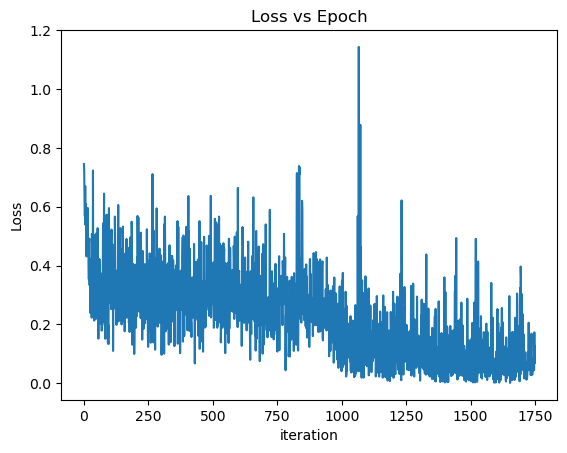

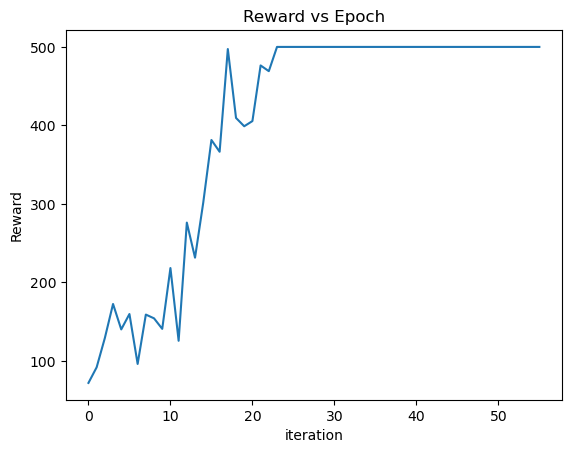

<Figure size 640x480 with 0 Axes>

In [17]:
# save to /mnt/nfs/work/c98181/RL/CartPole-v1/BC
# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(graph)
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/BC/loss.png")

# draw the reward graph
plt.plot(eval_rewards)
plt.xlabel("iteration")
plt.ylabel("Reward")
plt.title("Reward vs Epoch")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/BC/reward.png")


